# Precision - Recall

### Dataset : Amazon Reviews

In [1]:
import pandas as pd
import numpy as np

products = pd.read_csv("amazon_baby.csv")

### Preprocessing

In [2]:
products = products.fillna({'review':''})  # fill in N/A's in the review column

import string

def remove_punctuation(text):
    remove_punct_map = dict.fromkeys(map(ord, string.punctuation))
    return text.translate(remove_punct_map)

products['review_clean'] = products['review'].apply(remove_punctuation)

products = products[products['rating'] != 3]

products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

import json

with open("module-9-assignment-train-idx.json") as json_file:
    train_idx = json.load(json_file)
    
with open("module-9-assignment-test-idx.json") as json_file:
    test_idx = json.load(json_file)

train_data = products.iloc[train_idx]
test_data = products.iloc[test_idx]
print(train_data.shape)
print(test_data.shape)

(133416, 5)
(33336, 5)


### WordCount - Sparse Matrices using CountVectorizer

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
     # Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

In [4]:
print(train_matrix.shape)
print(test_matrix.shape)

(133416, 121712)
(33336, 121712)


In [5]:
train_data.head()

,name,review,rating,review_clean,sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,it came early and was not disappointed i love ...,1
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,Very soft and comfortable and warmer than it l...,1
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,This is a product well worth the purchase I h...,1
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,All of my kids have cried nonstop when I tried...,1
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,When the Binky Fairy came to our house we didn...,1


### Model and Training

In [6]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(train_matrix, train_data['sentiment'])

C:\Users\abido\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\abido\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### Evaluation

In [7]:
from sklearn.metrics import accuracy_score

In [8]:
# Test Accuracy
accuracy = accuracy_score(y_true=test_data['sentiment'].values, y_pred=model.predict(test_matrix))
print("Test Accuracy: {}".format(accuracy))

Test Accuracy: 0.9320254379649628


In [9]:
# Baseline: Majority class prediction
baseline = len(test_data[test_data['sentiment'] == 1])/len(test_data)
print("Baseline accuracy (majority class classifier): {}".format(baseline))

Baseline accuracy (majority class classifier): 0.8427825773938085


### Confusion Matrix

In [10]:
from sklearn.metrics import confusion_matrix

In [11]:
cmat = confusion_matrix(y_true=test_data['sentiment'].values,
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_)    # use the same order of class as the LR model.

In [12]:
print(' target_label | predicted_label | count ')
print('--------------+-----------------+-------')
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print('{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j]))

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3786
     -1       |        1        |  1455
      1       |       -1        |   811
      1       |        1        | 27284


In [13]:
tn, fp, fn, tp = confusion_matrix(y_true=test_data['sentiment'].values,
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_).ravel()

### Precision

In [15]:
from sklearn.metrics import precision_score

precision = precision_score(y_true=test_data['sentiment'].values, 
                            y_pred=model.predict(test_matrix))
print("Precision on test data: {}".format(precision))
# tp / (tp+fp)    ---> 94% of positively classifed examples are really positive


Precision on test data: 0.949371933609381


### Recall

In [16]:
from sklearn.metrics import recall_score
recall = recall_score(y_true=test_data['sentiment'].values,
                      y_pred=model.predict(test_matrix))
print("Recall on test data: %s" % recall)

# tp / (tp + fn) ---> 97% of all positive examples were classified as positive by the model

Recall on test data: 0.9711336536750311


### Changing the threshold

In [17]:
# The function should return an array, where each element is set to +1 or -1 depending whether the corresponding probability exceeds threshold.
def apply_threshold(probabilities, threshold):
    return (probabilities > threshold)*2 - 1

probabilities = model.predict_proba(test_matrix)[:,1]

preds05 = apply_threshold(probabilities, 0.5)
preds09 = apply_threshold(probabilities, 0.9)

In [18]:
print(sum(preds05 == 1))
print(sum(preds09 == 1))

28739
25076


In [19]:
precision05 = precision_score(y_true=test_data['sentiment'].values, 
                            y_pred= preds05)
precision09 = precision_score(y_true=test_data['sentiment'].values, 
                            y_pred= preds09)

recall05 = recall_score(y_true=test_data['sentiment'].values,
                      y_pred=preds05)
recall09 = recall_score(y_true=test_data['sentiment'].values,
                      y_pred=preds09)

print("Using 0.5 as threshold precision: {}, recall: {}".format(precision05, recall05))
print("Using 0.9 as threshold precision: {}, recall: {}".format(precision09, recall09))

Using 0.5 as threshold precision: 0.949371933609381, recall: 0.9711336536750311
Using 0.9 as threshold precision: 0.9814563726272133, recall: 0.8759921694251647


### Precision-Recall Curve

In [21]:
threshold_values = np.linspace(0.5, 1, num=100)
print(threshold_values)

[0.5        0.50505051 0.51010101 0.51515152 0.52020202 0.52525253
 0.53030303 0.53535354 0.54040404 0.54545455 0.55050505 0.55555556
 0.56060606 0.56565657 0.57070707 0.57575758 0.58080808 0.58585859
 0.59090909 0.5959596  0.6010101  0.60606061 0.61111111 0.61616162
 0.62121212 0.62626263 0.63131313 0.63636364 0.64141414 0.64646465
 0.65151515 0.65656566 0.66161616 0.66666667 0.67171717 0.67676768
 0.68181818 0.68686869 0.69191919 0.6969697  0.7020202  0.70707071
 0.71212121 0.71717172 0.72222222 0.72727273 0.73232323 0.73737374
 0.74242424 0.74747475 0.75252525 0.75757576 0.76262626 0.76767677
 0.77272727 0.77777778 0.78282828 0.78787879 0.79292929 0.7979798
 0.8030303  0.80808081 0.81313131 0.81818182 0.82323232 0.82828283
 0.83333333 0.83838384 0.84343434 0.84848485 0.85353535 0.85858586
 0.86363636 0.86868687 0.87373737 0.87878788 0.88383838 0.88888889
 0.89393939 0.8989899  0.9040404  0.90909091 0.91414141 0.91919192
 0.92424242 0.92929293 0.93434343 0.93939394 0.94444444 0.94949

In [22]:
preds_all = []
precision_all = []
recall_all = []

for threshold in threshold_values:
    preds_all.append(apply_threshold(probabilities, threshold))

y_true = test_data['sentiment'].values
for preds in preds_all:
    precision_all.append(precision_score(y_true=y_true, y_pred= preds))
    recall_all.append(recall_score(y_true=y_true, y_pred=preds))

C:\Users\abido\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [23]:
import matplotlib.pyplot as plt

def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})


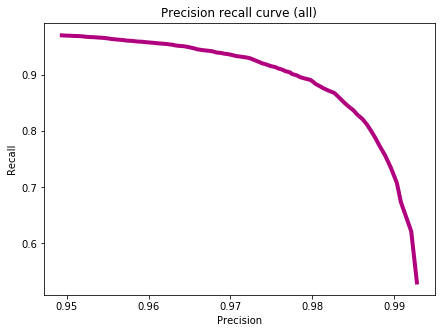

In [24]:
plot_pr_curve(precision_all[:-1], recall_all[:-1], 'Precision recall curve (all)')

### Precision Recall Curve on all test data

C:\Users\abido\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


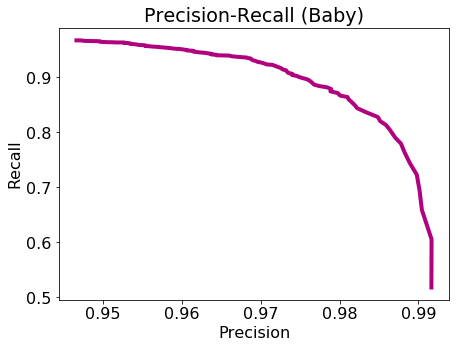

In [25]:
test_data = test_data.fillna({'name':''}) 

baby_reviews = test_data[test_data['name'].apply(lambda x: 'baby' in x.lower())]


baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
probabilities = model.predict_proba(baby_matrix)[:,1]

threshold_values = np.linspace(0.5, 1, num=100)

preds_all = []
precision_all = []
recall_all = []

for threshold in threshold_values:
    preds_all.append(apply_threshold(probabilities, threshold))

y_true = baby_reviews['sentiment'].values
for preds in preds_all:
    precision_all.append(precision_score(y_true=y_true, y_pred= preds))
    recall_all.append(recall_score(y_true=y_true, y_pred=preds))

plot_pr_curve(precision_all[:-1], recall_all[:-1], "Precision-Recall (Baby)")
